In [6]:
import pm4py
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import sorting

In [7]:
LOG_PATH = "bpi-chall.xes"

elog = pm4py.read_xes(LOG_PATH)

if isinstance(elog, pd.DataFrame):
    elog = log_converter.apply(elog, variant=log_converter.Variants.TO_EVENT_LOG)

elog = sorting.sort_timestamp(elog, timestamp_key="time:timestamp")

print(type(elog))
print(f"Number of cases: {len(elog)}")

parsing log, completed traces :: 100%|██████████| 31509/31509 [00:33<00:00, 952.21it/s] 


<class 'pm4py.objects.log.obj.EventLog'>
Number of cases: 31509


In [8]:
import numpy as np

In [9]:
df = log_converter.apply(elog, variant=log_converter.Variants.TO_DATA_FRAME)

df_sorted = df.sort_values(["case:concept:name", "time:timestamp"])

case_agg = df_sorted.groupby("case:concept:name").agg(
    start_time=("time:timestamp", "min"),
    end_time=("time:timestamp", "max"),
    n_events=("concept:name", "count"),
    n_activities=("concept:name", pd.Series.nunique),
)

case_agg["duration_hours"] = (case_agg["end_time"] - case_agg["start_time"]).dt.total_seconds() / 3600
case_agg["duration_days"] = case_agg["duration_hours"] / 24

print("Number of cases in case_agg:", len(case_agg))
print(case_agg[["duration_days", "n_events", "n_activities"]].describe())


Number of cases in case_agg: 31509
       duration_days      n_events  n_activities
count   31509.000000  31509.000000  31509.000000
mean       21.899606     38.156305     15.532324
std        13.169233     16.715308      2.493093
min         0.002327     10.000000      8.000000
25%        11.324672     25.000000     13.000000
50%        19.087739     35.000000     16.000000
75%        31.495729     47.000000     18.000000
max       286.072438    180.000000     21.000000


In [10]:
q75 = case_agg["duration_days"].quantile(0.75)
case_agg["long_case"] = (case_agg["duration_days"] > q75).astype(int)

print("75th percentile duration (days):", q75)
print(case_agg["long_case"].value_counts())
print(case_agg["long_case"].value_counts(normalize=True))


75th percentile duration (days): 31.495728541666665
long_case
0    23632
1     7877
Name: count, dtype: int64
long_case
0    0.750008
1    0.249992
Name: proportion, dtype: float64


In [11]:
prefix_df = df_sorted.groupby("case:concept:name").head(3).copy()
prefix_df["pos"] = prefix_df.groupby("case:concept:name").cumcount() + 1

first3 = prefix_df.pivot(index="case:concept:name", columns="pos", values="concept:name")

for i in range(1, 4):
    if i not in first3.columns:
        first3[i] = np.nan

first3 = first3[[1, 2, 3]]
first3.columns = ["act_pos_1", "act_pos_2", "act_pos_3"]

features = case_agg.join(first3, how="left")

print(features.head())

                                             start_time  \
case:concept:name                                         
Application_1000086665 2016-08-03 15:57:21.673000+00:00   
Application_1000158214 2016-06-02 10:14:26.844000+00:00   
Application_1000311556 2016-04-04 15:56:37.675000+00:00   
Application_1000334415 2016-09-15 16:39:17.758000+00:00   
Application_1000339879 2016-03-17 12:57:10.159000+00:00   

                                               end_time  n_events  \
case:concept:name                                                   
Application_1000086665 2016-09-05 06:00:36.893000+00:00        22   
Application_1000158214 2016-06-10 11:02:01.282000+00:00        25   
Application_1000311556 2016-05-05 06:00:48.963000+00:00        18   
Application_1000334415 2016-09-29 07:45:34.389000+00:00        40   
Application_1000339879 2016-03-30 09:11:48.600000+00:00        51   

                        n_activities  duration_hours  duration_days  \
case:concept:name              

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [13]:
features_ml = features.dropna(subset=["act_pos_1"]).copy()

X = features_ml[["n_events", "n_activities", "act_pos_1", "act_pos_2", "act_pos_3"]]
y = features_ml["long_case"]

categorical_cols = ["act_pos_1", "act_pos_2", "act_pos_3"]
numeric_cols = ["n_events", "n_activities"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4727
           1       0.68      0.64      0.66      1575

    accuracy                           0.83      6302
   macro avg       0.78      0.77      0.77      6302
weighted avg       0.83      0.83      0.83      6302

Confusion matrix:
[[4257  470]
 [ 573 1002]]
ROC AUC: 0.8633631854829231


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

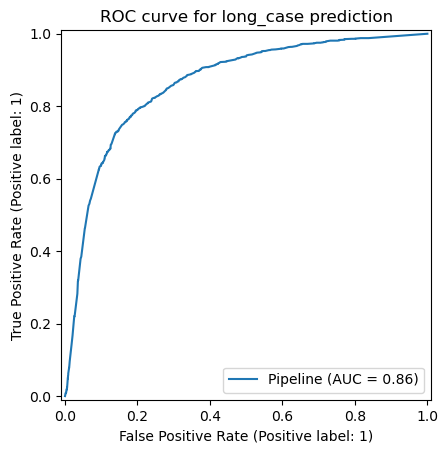

In [15]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC curve for long_case prediction")
plt.show()

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.3f}")
print(f"Precision (1): {prec:.3f}")
print(f"Recall (1): {rec:.3f}")
print(f"F1 (1): {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

Accuracy:      0.834
Precision (1): 0.681
Recall (1):    0.636
F1 (1):        0.658
ROC AUC:       0.863


In [18]:
from sklearn.metrics import PrecisionRecallDisplay

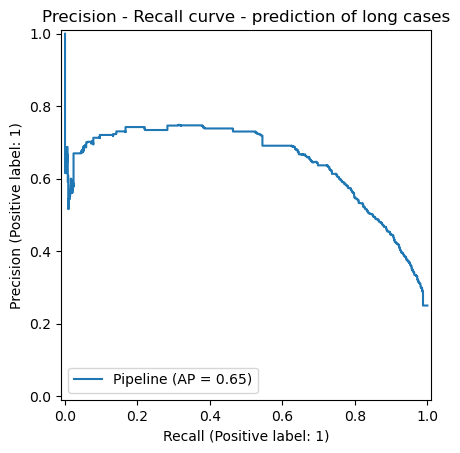

In [19]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax)
ax.set_title("Precision - Recall curve - prediction of long cases")
plt.show()

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

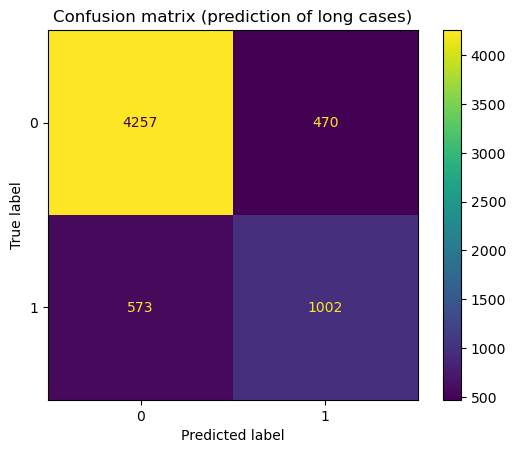

In [25]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax)
ax.set_title("Confusion matrix (prediction of long cases)")
plt.show()

In [22]:
rf = clf.named_steps["model"]
preprocess = clf.named_steps["preprocess"]

ohe = preprocess.named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(["act_pos_1", "act_pos_2", "act_pos_3"]))

numeric_feature_names = ["n_events", "n_activities"]

all_feature_names = ohe_feature_names + numeric_feature_names

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

top_n = 15
top_indices = indices[:top_n]

print("Top feature importances:")
for idx in top_indices:
    print(f"{all_feature_names[idx]}: {importances[idx]:.4f}")

Top feature importances:
n_activities: 0.4868
n_events: 0.3893
act_pos_3_W_Handle leads: 0.0341
act_pos_2_A_Submitted: 0.0333
act_pos_3_W_Complete application: 0.0319
act_pos_2_W_Complete application: 0.0178
act_pos_2_A_Concept: 0.0067
act_pos_1_A_Create Application: 0.0000


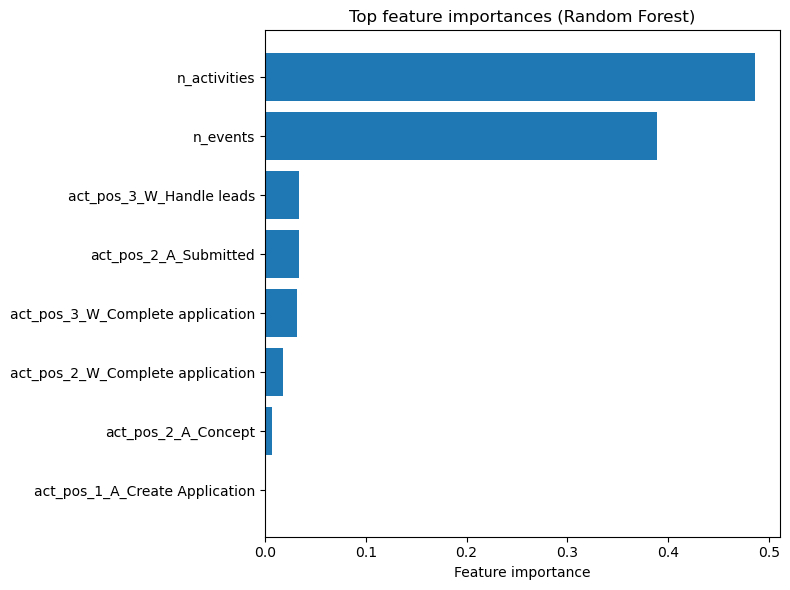

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(
    [all_feature_names[i] for i in reversed(top_indices)],
    [importances[i] for i in reversed(top_indices)]
)
ax.set_xlabel("Feature importance")
ax.set_title("Top feature importances (Random Forest)")
plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import jaccard_score

jaccard = jaccard_score(y_test, y_pred, pos_label=1)
print("Jaccard score (c1):", jaccard)

Jaccard score (c1): 0.4899755501222494
